## Problem Definition

We are addressing an **image classification problem** with four distinct categories: *budgie*, *rubber duck*, *canary*, and *duckling*. The dataset consists of both **labeled** and **unlabeled images**. While the labeled data offers ground truth for model training, a significant portion of the dataset remains unlabeled, adding complexity to the task.

The objective is to develop a model that can leverage both the labeled and unlabeled data to enhance performance. The challenge lies in effectively utilizing the unlabeled data to improve classification accuracy and robustness.

### Requirements:
- The model must be implemented using **`torch`** and **`torchvision`** only (no other deep learning libraries are allowed for the model architecture).
- The main class for the model must be named <font color='red'>**`Model`**</font>, and participants <font color='red'>**must not change this name**</font>.
- Do not change the init function inside the **`Model`** class.
- The size of your model should not exceed 70 MB.
- Instantiating your model must not require any parameters.


In [ ]:
# from datasets import load_dataset
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision import transforms
import os
import sys
from huggingface_hub import snapshot_download
from PIL import Image
from typing import Tuple, List
import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
dataset_id = "RayanAi/Noisy_birds"
# Set the local directory where you want to store the dataset
local_dataset_dir = "./Noisy_birds"  # You can change this path to your desired location

# Create the directory if it doesn't exist
os.makedirs(local_dataset_dir, exist_ok=True)

# Suppress the output by redirecting it to os.devnull
with open(os.devnull, 'w') as fnull:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to devnull to suppress output
        sys.stdout = fnull
        # Download the dataset and store it locally
        snapshot_download(repo_id=dataset_id, local_dir=local_dataset_dir, repo_type="dataset")
    finally:
        # Restore the original stdout
        sys.stdout = original_stdout

# Print message when download is complete
print("Dataset downloaded completely.")

# Calculate and print the total size of the downloaded files
total_size = 0
for dirpath, dirnames, filenames in os.walk(local_dataset_dir):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

# Convert size to MB and print
print(f"Total size of downloaded files: {total_size / (1024 * 1024):.2f} MB")

# Get the absolute path of the dataset directory and print it
dataset_abs_path = os.path.abspath(local_dataset_dir)
print(f"Dataset has been saved at: [{dataset_abs_path}]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Noisy_birds.zip:   0%|          | 0.00/7.98M [00:00<?, ?B/s]

Dataset downloaded completely.
Total size of downloaded files: 7.61 MB
Dataset has been saved at: [/content/Noisy_birds]


In [ ]:
!unzip -qo ./Noisy_birds/Noisy_birds.zip -d ./Noisy_birds/

## Dataset

In this part, the dataset is downloaded and needed agumentation functions are applied. You only need to define the necessary transform functions for augmentation. At the end you are provided with a train_loader, val_loader and a test_loader.

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
#Define the split ratio
split_ratio = 0.6

#Dataset function called
class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. . Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
        """
        # Initialize paths and transformation
        self.allowed_classes=allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes = [item for item in os.listdir(self.image_dir) if os.path.isdir(os.path.join(self.image_dir, item))]
        self.samples=[]
        for class_name in self.classes:
                if class_name in allowed_classes:

                    self.images = os.listdir(os.path.join(self.image_dir, class_name))
                    for img in self.images:
                        self.samples.append([img,class_name])

        random.seed(87)
        random.shuffle(self.samples)

        # print(self.samples)

        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples

    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        # Return the length of the dataset (number of images)
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - onehot_mask (torch.Tensor): One-hot encoded mask tensor for segmentation.
        """
        # Load the image and mask
        image_path = os.path.join(self.image_dir,self.images[index][1],self.images[index][0])



        # Load image and mask as grayscale
        image = Image.open(image_path)
        if self.transform:
            transformed = self.transform(image)
        else:
            transformed = transform_test(image)

        class_id = self.allowed_classes.index(self.images[index][1])

        return transformed, class_id



In [ ]:
train_dataset = Birddataset(
    image_dir="./Noisy_birds",
    allowed_classes=["budgie","canary","duckling","rubber duck"],
    transform=transform,

    dataset_type='Train',

)

val_dataset = Birddataset(
    image_dir= "./Noisy_birds",
    allowed_classes=["budgie","canary","duckling","rubber duck"],
    transform=transform_test,
    dataset_type='Test',

)

unlabeled_dataset = Birddataset(
    image_dir="./Noisy_birds",
    allowed_classes=["unlabeled"],

)

In [ ]:
batch_size = 128
num_workers = 2 # Change if you have beefy CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

## CNN
The size of your model should not exceed 70 MB.

In [ ]:
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Load the pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)  # Using EfficientNet-B0, you can scale this up

        # Modify the last fully connected layer to output 4 classes
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 4)  # 4 output classes: budgie, rubber duck, canary, duckling
        )

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth",weights_only=True))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Input:
        - x: A 4D input tensor representing a batch of images, with shape (batch_size, channels, height, width).
            For instance, for a batch of RGB images of size 128x128, the shape would be (batch_size, 3, 128, 128).

        Output:
        - A tensor of shape (batch_size, num_classes), where `num_classes` corresponds to the number of target classes
        for classification. In this case it is 4.
        """
        #Your code here
        return self.efficientnet(x)

In [ ]:
model = Model()
model.to(device)
output = model(torch.randn(128,3,128,128).cuda())
assert output.shape==(128,4), "The output of your model does not have correct dimmensions"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 193MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()  # For labeled data
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train

Here is the training functions. You should can use this function in the next part to train your model. It employes early stopping and returns the model and scores in the output.

In [ ]:
from tqdm import tqdm
def train(model: nn.Module, dataloader: DataLoader, num_epochs: int = 30,patience: int = 30, lr: float = 0.001) -> Tuple[nn.Module, List[List[float]]]:
    """
    Function to train the model.

    Input:
        model: The CNN model to be trained.
        dataloader: The DataLoader that provides the training and validation data.
        num_epochs: Number of epochs to train the model for (default is 30).
        lr: The learning rate (default is 0.001).

    Output:
        model: Best version of the trained model.
        scores: A list containing two lists: [training_losses, validation_losses].
    """

    scores = [[], []]



    best_val_loss = float('inf')  # Initialize with a large value
    best_model_state = None
    counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Ensure the model is in training mode

        for (inputs, labels) in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item() * len(inputs)

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss
        scores[0].append(avg_train_loss)

        # Evaluation
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # No need to track gradients for validation
            for inputs, labels in val_loader:  # Using the global val_loader

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_val_loss += loss.item() * len(inputs)
                # Store predictions and true labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss for the epoch
        avg_val_loss = running_val_loss
        scores[1].append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            counter = 0  # Reset counter if the validation loss improves
        else:
            counter += 1  # Increment counter if the validation loss does not improve

        # Early stopping check
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # After training, load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    all_preds = []
    all_labels = []
    with torch.no_grad():  # No need to track gradients for validation
        running_loss = 0.0
        for inputs, labels in val_loader:  # Using the global test_loader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 Score
    accuracy_counter=0
    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            accuracy_counter+=1
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'micro' or 'macro' depending on your needs
    print(f'F1 Score on the Validation set: {f1:.4f}')
    print(f'Accuracy on the Validation set: {accuracy_counter/len(all_labels):.4f}')
    print(all_labels)
    print(all_preds)
    return model, scores


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(scores):
    """
    Plot the training and validation losses.

    Parameters:
    - scores: A list containing two lists [training_losses, validation_losses]
    """
    train_losses = scores[0]
    val_losses = scores[1]

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Train your model.

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch 1/30, Training Loss: 126.8031, Validation Loss: 80.8083


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 2/30, Training Loss: 98.7615, Validation Loss: 76.8451


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 3/30, Training Loss: 75.1669, Validation Loss: 73.0555


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 4/30, Training Loss: 52.4705, Validation Loss: 69.5729


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 5/30, Training Loss: 35.5521, Validation Loss: 66.0631


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 6/30, Training Loss: 19.9115, Validation Loss: 64.1793


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 7/30, Training Loss: 11.9367, Validation Loss: 63.1809


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 8/30, Training Loss: 6.9430, Validation Loss: 63.0775


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 9/30, Training Loss: 4.2660, Validation Loss: 64.1699


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 10/30, Training Loss: 1.9900, Validation Loss: 66.5972


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch 11/30, Training Loss: 1.3161, Validation Loss: 69.9872


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 12/30, Training Loss: 0.8441, Validation Loss: 73.8523


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 13/30, Training Loss: 0.6026, Validation Loss: 78.2871


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 14/30, Training Loss: 0.5342, Validation Loss: 82.5319


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 15/30, Training Loss: 0.2726, Validation Loss: 86.8963


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 16/30, Training Loss: 0.4761, Validation Loss: 91.0300


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 17/30, Training Loss: 0.2055, Validation Loss: 95.0447


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 18/30, Training Loss: 0.1319, Validation Loss: 98.2895
Early stopping triggered after 18 epochs.
Best model loaded based on validation loss.
F1 Score on the Validation set: 0.7339
Accuracy on the Validation set: 0.7333
[3, 2, 0, 3, 3, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1, 3, 0, 3, 2, 3, 1, 2, 3, 3, 1, 2, 2, 3, 1, 1, 3, 3, 2, 0, 3, 0, 3, 0, 2, 2, 2, 0, 1, 1, 0, 3, 2, 0, 3, 0, 3, 1, 3, 2, 0, 1, 2, 0]
[3, 2, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 3, 2, 3, 0, 2, 3, 3, 1, 1, 2, 3, 1, 1, 3, 3, 2, 0, 3, 1, 1, 3, 2, 2, 2, 1, 1, 1, 0, 3, 2, 1, 3, 0, 3, 0, 3, 3, 0, 3, 2, 0]


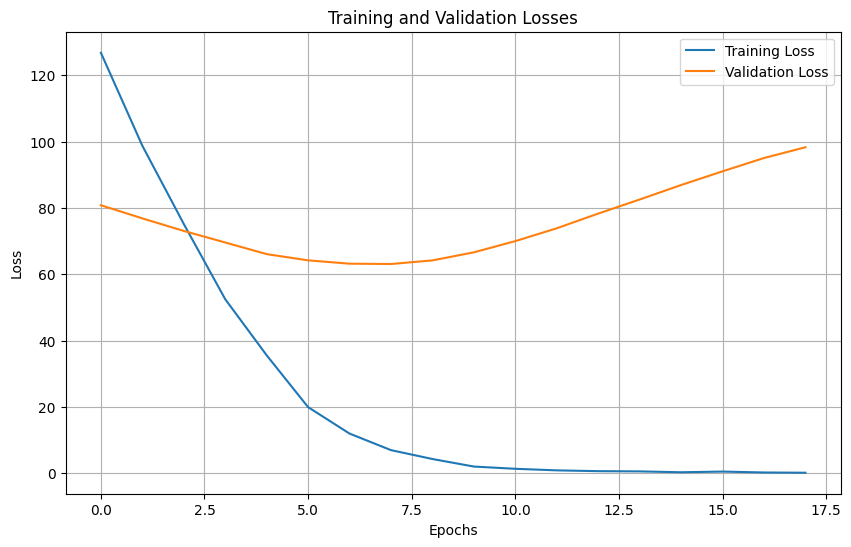

In [ ]:
num_epochs=30
patience=10
lr=0.001
model, training_scores = train(model,train_loader, num_epochs=num_epochs,patience = patience,lr = lr)
plot_losses(training_scores)

In [ ]:
model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)